In [1]:
"""

10k_pycistopic_modelling.ipynb

This script is used to create the pycistopic object

authors: Roy Oelen

"""

'\n\n10k_pycistopic_modelling.ipynb\n\nThis script is used to create the pycistopic object\n\nauthors: Roy Oelen\n\n'

In [24]:
# imports
from pycisTopic.cistopic_class import CistopicObject
from scipy.sparse import csr_matrix
from scipy.io import mmread
import gzip
from sklearn.preprocessing import binarize
import pandas as pd
import os
from pycisTopic.lda_models import run_cgs_models_mallet
from numpy.random import choice
from pycisTopic.lda_models import evaluate_models
import pickle
import numpy as np
import glob
import re
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)
# imputation
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)


In [3]:
#######################################
# read the openness to nucleus matrix #
#######################################

# location of matrix
fragment_matrix_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/deconstructed/matrix.mtx.gz'
with open(fragment_matrix_loc, 'rb') as f:
    coo_fragment_matrix = mmread(fragment_matrix_loc)

# convert to csr format
fragment_matrix = csr_matrix(coo_fragment_matrix)


In [4]:
# locations
barcodes_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/deconstructed/barcodes.tsv.gz'
features_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/deconstructed/features.tsv.gz'

# load region names
region_names_file = gzip.open(features_loc, 'rb')
region_names = pd.read_csv(region_names_file, sep='\t', header=None).iloc[:,0].to_list()
region_names = [i.replace('-', ':', 1) for i in region_names]

# Read cell names
cell_names_file = gzip.open(barcodes_loc, 'rb')
cell_names = pd.read_csv(cell_names_file, sep='\t', header=None).iloc[:,0].to_list()


In [14]:
#########################################
# set up path to all the fragment files #
#########################################

# add the path
fragment_files = ['/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/rounding/10k_PBMC_Multiome_nextgem_Chromium_X_rounded_atac_fragments.tsv.gz']


In [15]:
#############################
# read the nucleus metadata #
#############################

# location of the metadata for ATAC
atac_cell_metadata_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/deconstructed/metadata.tsv.gz'
atac_cell_metadata = pd.read_csv(atac_cell_metadata_loc, sep = '\t', low_memory = False)
# location of the metadata for RNA
rna_cell_metadata_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/seurat/10k_seurat_annotated_metadata.tsv.gz'
rna_cell_metadata = pd.read_csv(rna_cell_metadata_loc, sep = '\t', low_memory = False)
# merge what we find interesting
cell_metadata = atac_cell_metadata.merge(rna_cell_metadata[['barcode_1', 
                                                            'nCount_RNA', 
                                                            'nFeature_RNA', 
                                                            'nCount_SCT', 
                                                            'nFeature_SCT', 
                                                            'SCT_snn_res.1.2', 
                                                            'predicted.celltype.azi.l1', 
                                                            'predicted.celltype.azi.l1.score', 
                                                            'predicted.celltype.azi.l2', 
                                                            'predicted.celltype.azi.l2.score', 
                                                            'predicted.celltype.azi.l3', 
                                                            'predicted.celltype.azi.l3.score']], how = 'left', left_on = 'bc', right_on = 'barcode_1')
# Subset cell metadata 
cell_metadata = cell_metadata[cell_metadata.bc.isin(cell_names)]
# Filter cell names
cell_names = cell_metadata.bc.to_list()
# Names as rownames 
cell_metadata.index = cell_metadata.bc


In [17]:
#####################################
# binarize the accessibility matrix #
#####################################

# binarization of accessibility matrix
fragment_matrix_binarized = binarize(fragment_matrix, threshold=0)


In [21]:
##########################################
# create metadata for all of the regions #
##########################################

# location of the cpeaks annotation
cpeaks_annotation_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/cPeaks/cPeaks_info.tsv'
# read the annotations
cpeaks_annotation = pd.read_csv(cpeaks_annotation_loc, sep = ' ', low_memory = False)
# add a name column
cpeaks_annotation['name'] = cpeaks_annotation['chr_hg38'].astype(str) + ':' + cpeaks_annotation['start_hg38'].astype(str) + '-' + cpeaks_annotation['end_hg38'].astype(str)

# Subset region metadata metadata 
cpeaks_annotation = cpeaks_annotation[cpeaks_annotation.name.isin(region_names)]
# Names as rownames 
cpeaks_annotation.index = cpeaks_annotation.name


In [23]:
#############################
# create pycistopic object #
#############################

# construct object
cistopic_obj = CistopicObject(
    fragment_matrix=fragment_matrix,
    binary_matrix=fragment_matrix_binarized,
    cell_names=cell_names,
    region_names=region_names,
    region_data=cpeaks_annotation,
    cell_data=cell_metadata,
    path_to_fragments=fragment_files,
    project='10x_10k'
)


In [24]:
##########################
# save pycistopic object #
##########################

# location to store the object
pycistopic_object_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/reconstructed/10k_initial_pycistopic_object.pkl'

# save the object
with open(pycistopic_object_loc, 'wb') as f:
   pickle.dump(cistopic_obj, f)


In [3]:
##########################
# read pycistopic object #
##########################

# location to store the object
pycistopic_object_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/reconstructed/10k_initial_pycistopic_object.pkl'

# save the object
with open(pycistopic_object_loc, 'rb') as f:
   cistopic_obj = pickle.load(f)
    

In [4]:
#################################
# set paths for topic modelling #
#################################

# LDA will use Mallet, set the memory to be large enough
os.environ['MALLET_MEMORY'] = '100G'

# path to the Mallet binary
mallet_path = '/groups/umcg-franke-scrna/tmp04/software/Mallet-202108/bin/mallet'

# set temp directory
tmp_directory = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/tmp_space/'

# set where we save the pickles
models_save_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/models/'


In [ ]:
####################################
# run LDA on the pycistopic object #
####################################

# get the models
models = run_cgs_models_mallet(
    cistopic_obj,
    n_topics = [5, 10, 20, 30, 40],
    n_cpu = 8,
    n_iter = 500,
    random_state = 7777,
    alpha = 50,
    alpha_by_topic = True,
    eta = 0.1,
    eta_by_topic = False,
    tmp_path = tmp_directory,
    save_path = models_save_loc,
    mallet_path = mallet_path,
)


2025-05-14 19:10:08,666 cisTopic     INFO     Formatting input to corpus
2025-05-14 19:10:09,389 cisTopic     INFO     Running model with 5 topics
2025-05-14 19:10:09,390 LDAMalletWrapper INFO     Serializing temporary corpus to /groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/tmp_space/corpus.txt
2025-05-14 19:10:34,299 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /groups/umcg-franke-scrna/tmp04/software/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/tmp_space/corpus.txt --output /groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/tmp_space/corpus.mallet
2025-05-14 19:11:05,558 LDAMalletWrapper INFO     Training MALLET LDA with: /groups/umcg-franke-scrna/tmp04/software/Mallet-202108/bin/mallet train-topics --input /groups/umcg-franke-scrna/tmp04/external_dat

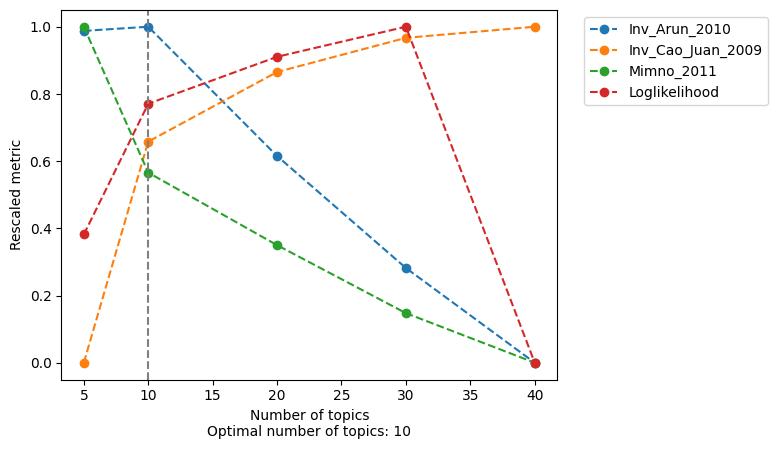

In [7]:
################
# select model #
################

# select 10 topics
model = evaluate_models(
    models,
    return_model = True,
    select_model = 10
)


In [8]:
# add that model to the object
cistopic_obj.add_LDA_model(model)


In [9]:
#################
# cluster cells #
#################

# perform KNN clustering
find_clusters(
    cistopic_obj,
    target  = 'cell',
    k = 10,
    res = [0.6, 1.2, 3],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)


2025-05-14 22:03:41,417 cisTopic     INFO     Finding neighbours


In [10]:
############
# run UMAP #
############

# perform 2D UMAP dimensional reduction
run_umap(
    cistopic_obj,
    target  = 'cell', 
    scale=True
)


2025-05-14 22:03:44,556 cisTopic     INFO     Running UMAP


/home/umcg-roelen/miniconda3/envs/pycistopic_env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


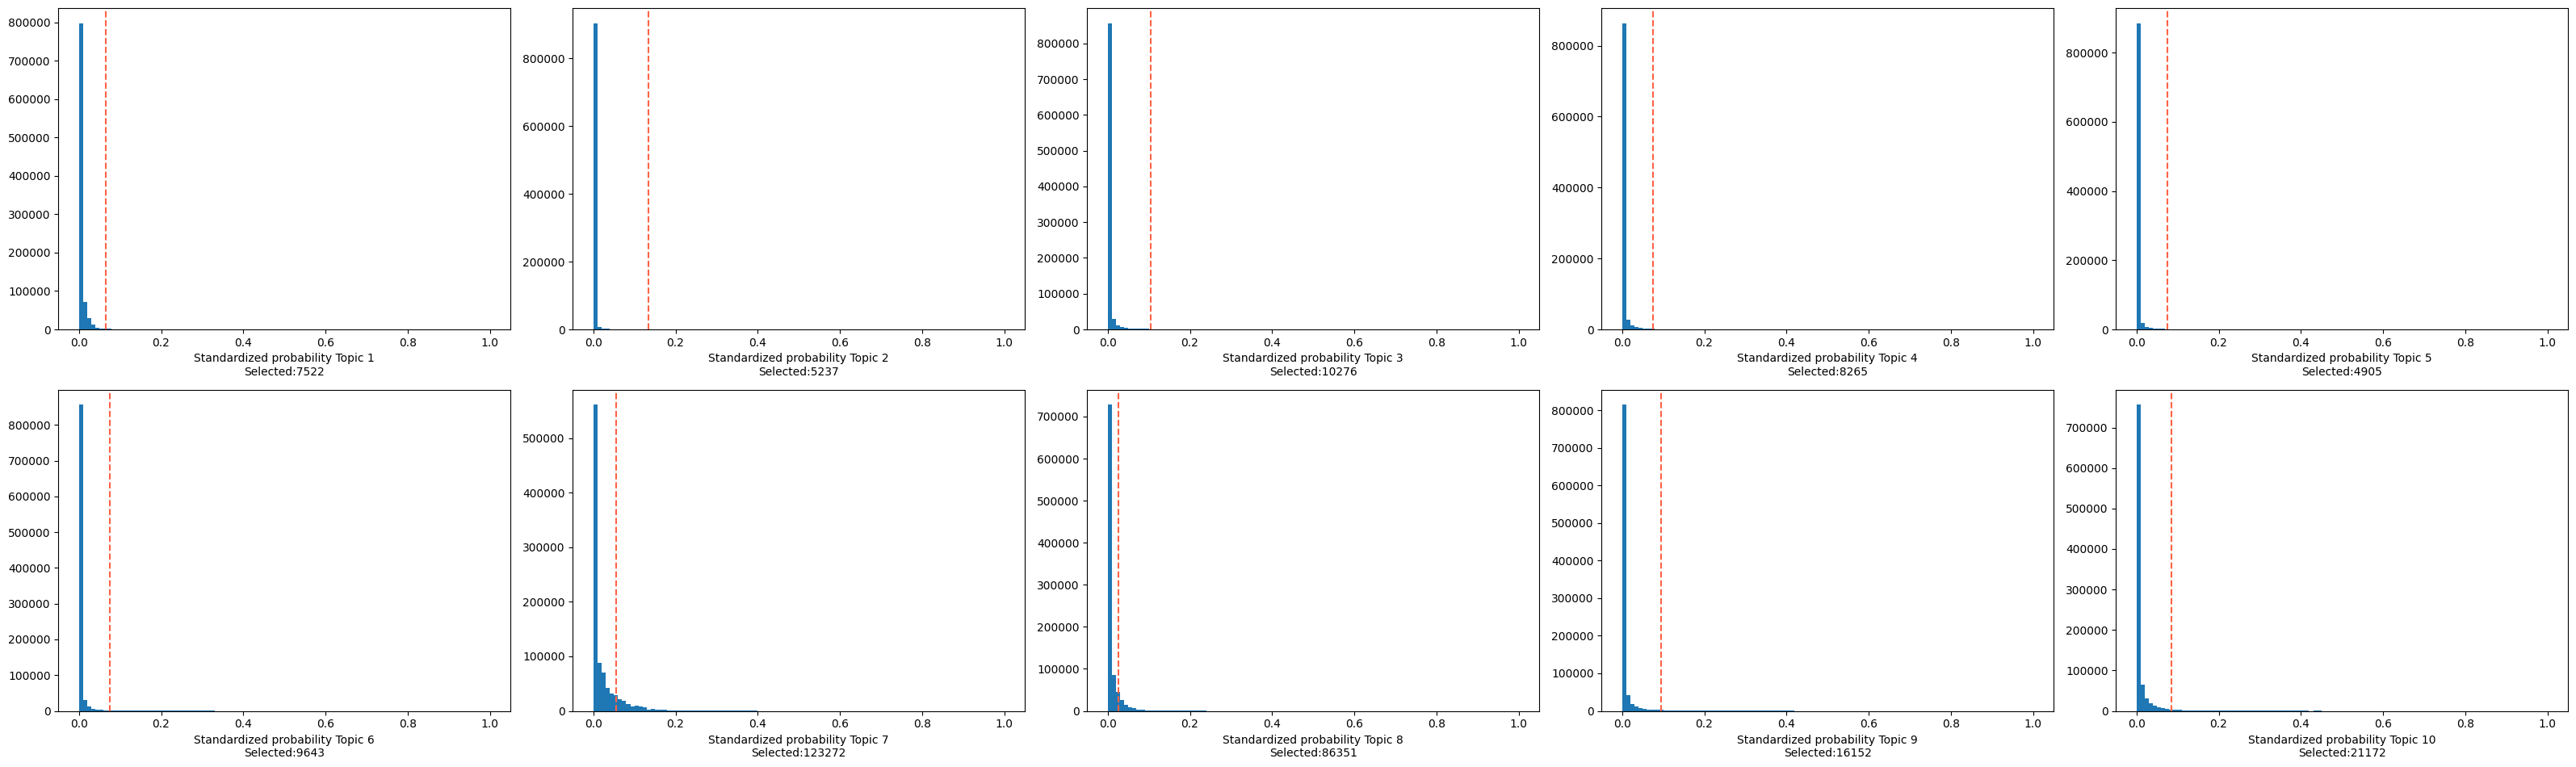

In [11]:
###################
# binarize topics #
###################

# run the binarization step for the regions
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, 
    method = 'otsu',
    plot = True, 
    num_columns = 5
)


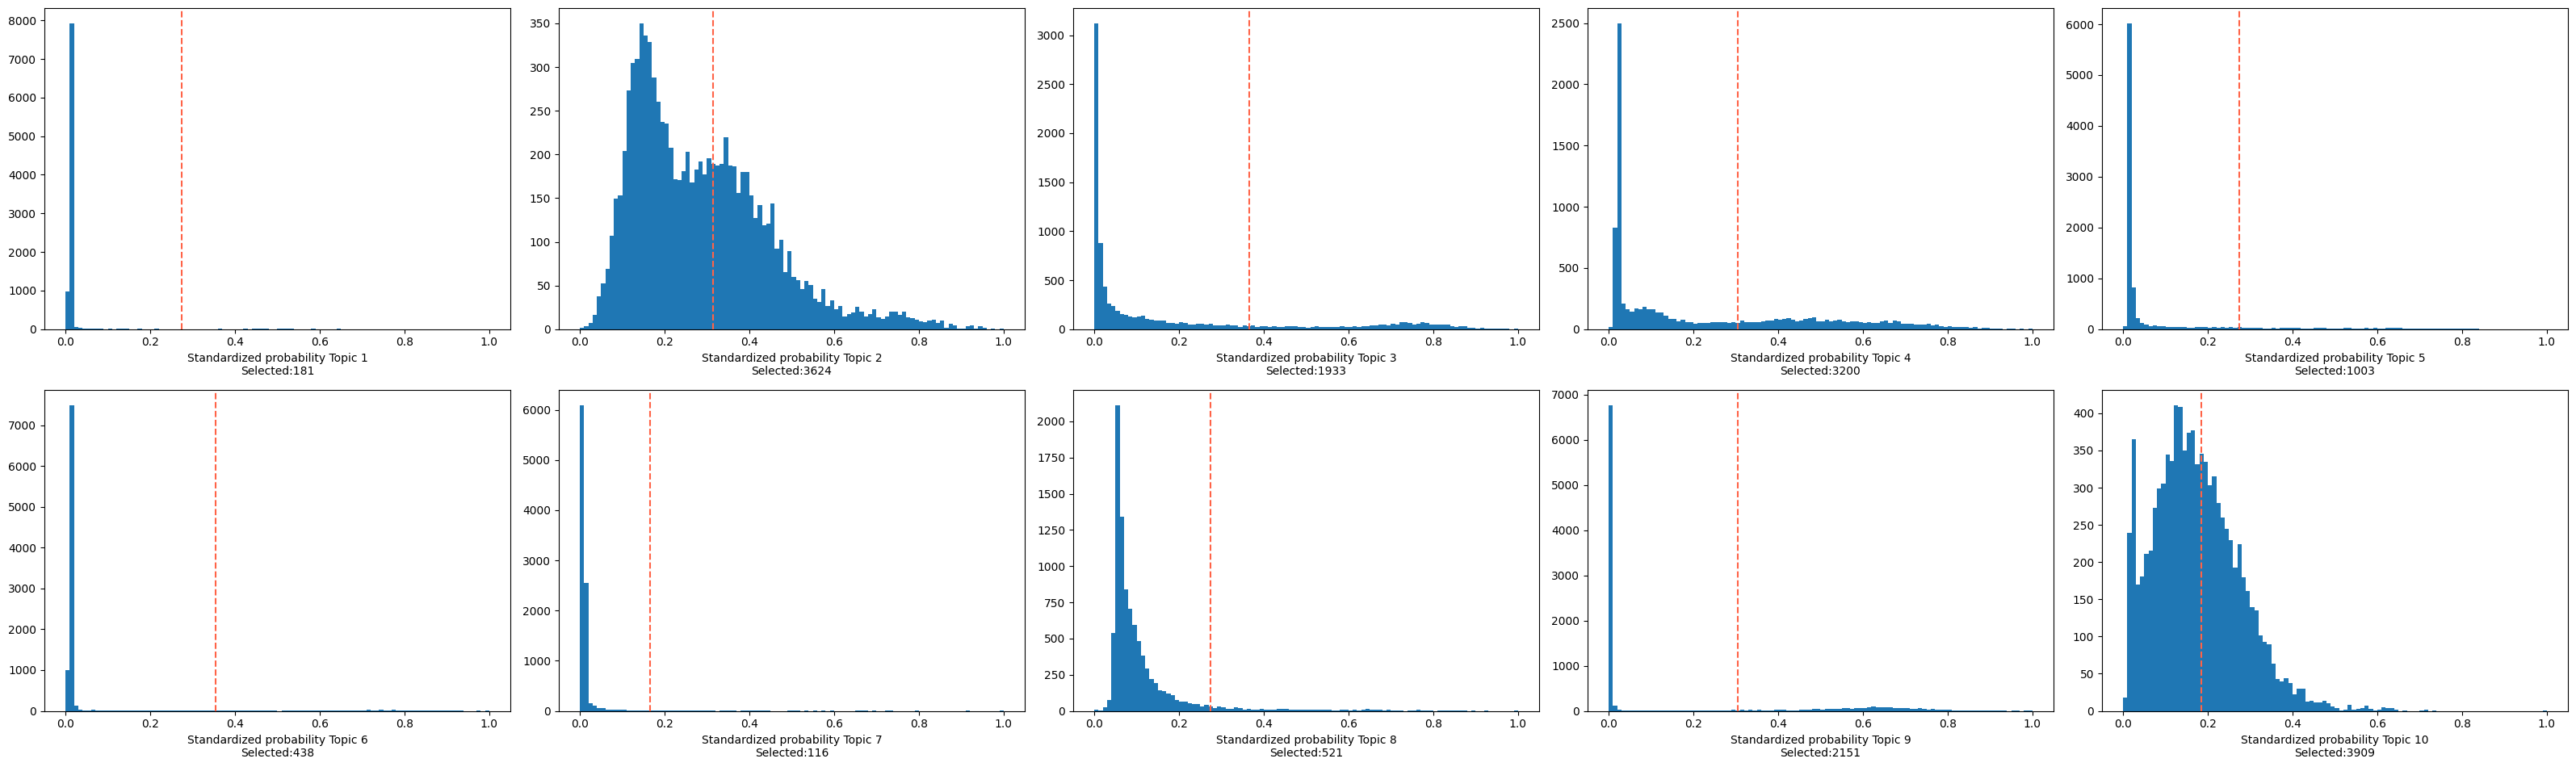

In [12]:
##################
# binarize cells #
##################

# run binarization for the cells
binarized_cell_topic = binarize_topics(
    cistopic_obj,
    target='cell',
    method='otsu',
    plot=True,
    num_columns=5, 
    nbins=100
)


In [13]:
#######################
# binarization export #
#######################

# locations of the binarizations
region_bin_topics_otsu_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/binarization/10k_region_to_topic_10.tsv.gz'
# merge all the columns
region_bin_topics_otsu_combined = pd.concat(region_bin_topics_otsu.values(), axis=1)
# write the file
region_bin_topics_otsu_combined.to_csv(region_bin_topics_otsu_loc, sep = '\t', header = True, index = True, compression = 'gzip')

# the same for the cell to topic
binarized_cell_topic_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/binarization/10k_cell_to_topic_10.tsv.gz'
binarized_cell_topic_combined = pd.concat(binarized_cell_topic.values(), axis=1)
binarized_cell_topic_combined.to_csv(binarized_cell_topic_loc, sep = '\t', header = True, index = True, compression = 'gzip')


In [14]:
#################
# topic metrics #
#################

# calculate the topic metrics
topic_qc_metrics = compute_topic_metrics(cistopic_obj)
# place the metrics in a plots
fig_dict={}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(topic_qc_metrics, var_x = 'Coherence', var_y = 'Log10_Assignments', var_color = 'Gini_index', plot = False, return_fig = True)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x = 'Log10_Assignments', var_y = 'Cells_in_binarized_topic', var_color = 'Gini_index', plot = False, return_fig = True)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x = 'Coherence', var_y = 'Cells_in_binarized_topic', var_color = 'Gini_index', plot = False, return_fig = True)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x ='Coherence', var_y = 'Regions_in_binarized_topic', var_color = 'Gini_index', plot = False, return_fig = True)
fig_dict['CoherenceVSMarginal_dist']= plot_topic_qc(topic_qc_metrics, var_x = 'Coherence', var_y = 'Marginal_topic_dist', var_color = 'Gini_index', plot = False, return_fig = True)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(topic_qc_metrics, var_x = 'Coherence', var_y = 'Gini_index', var_color = 'Gini_index', plot = False, return_fig = True)


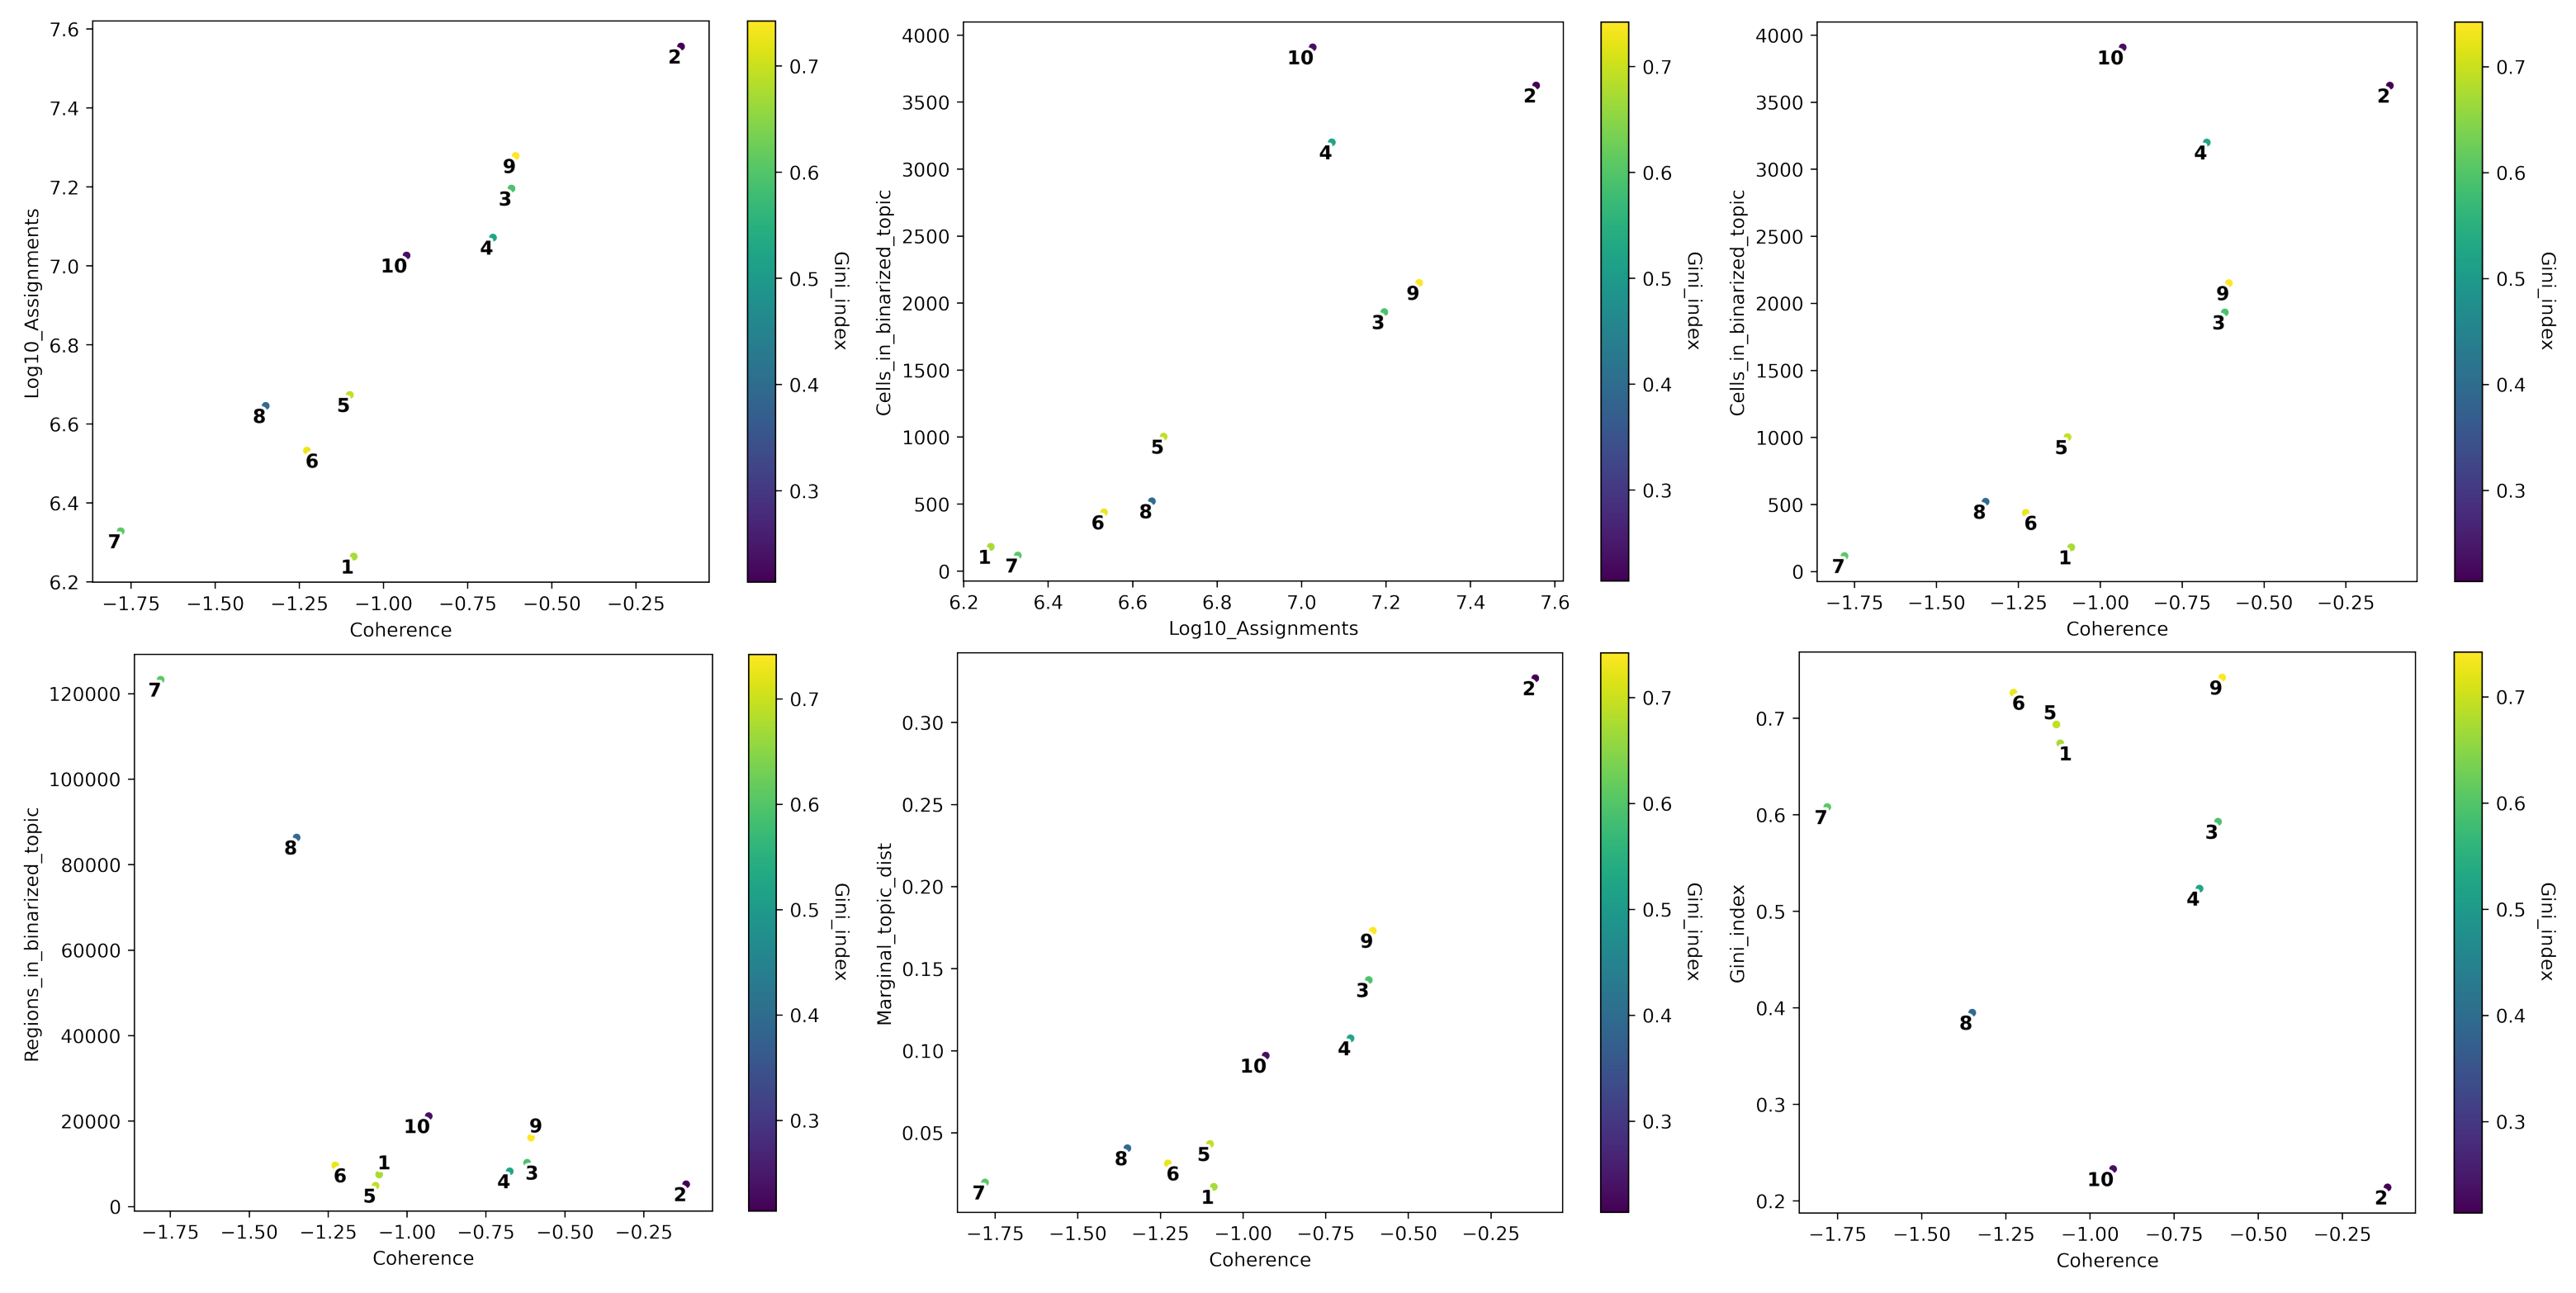

In [15]:
###############
# topic plots #
###############

# set up figure
fig=plt.figure(figsize=(40, 43))
# go through each plot
i = 1
for fig_ in fig_dict.keys():
    # turn into a subplot
    plt.subplot(2, 3, i)
    # make figure into png, to place in the multiplot
    img = fig2img(fig_dict[fig_])
    # show the png
    plt.imshow(img)
    plt.axis('off')
    # increase counter
    i += 1
# adjust spacing
plt.subplots_adjust(wspace=0, hspace=-0.70)
# show plot
plt.show()


In [17]:
########################
# topic metrics export #
########################

# location of topic metrics
topic_metrics_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/metrics/10k_topic_metrics_10.tsv.gz'
# write the file
topic_qc_metrics.to_csv(topic_metrics_loc, sep = '\t', header = True, index = False, compression = 'gzip')


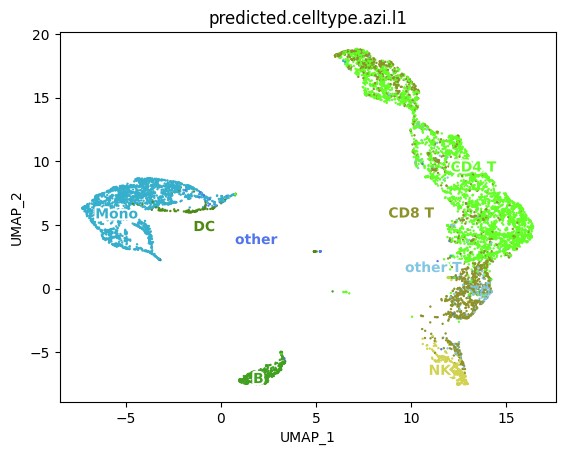

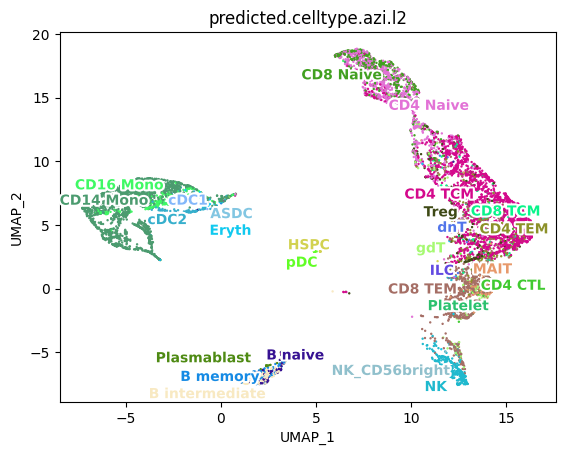

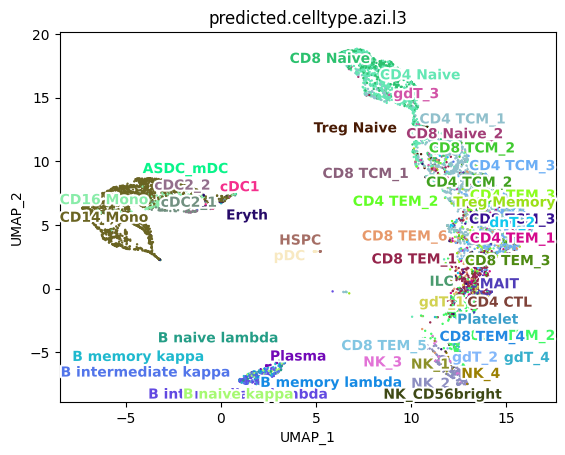

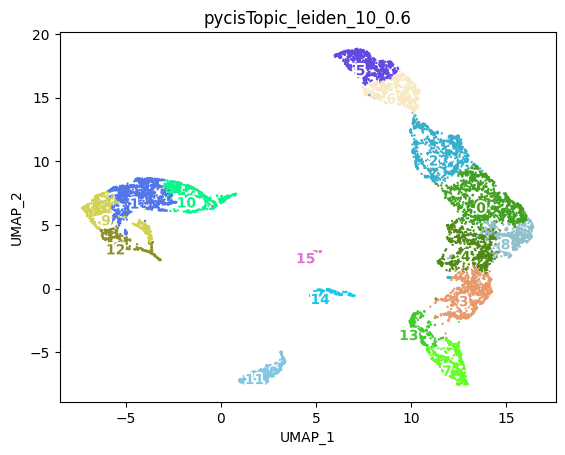

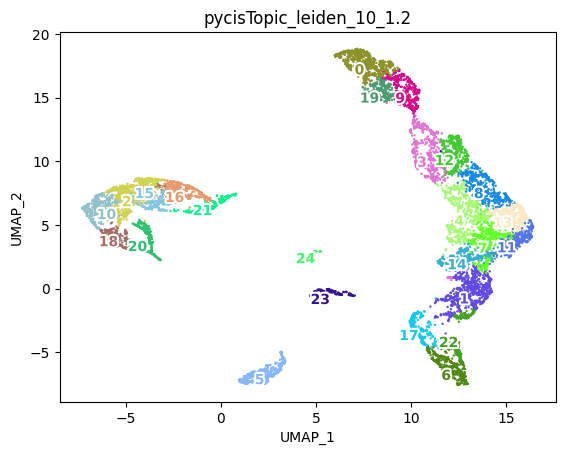

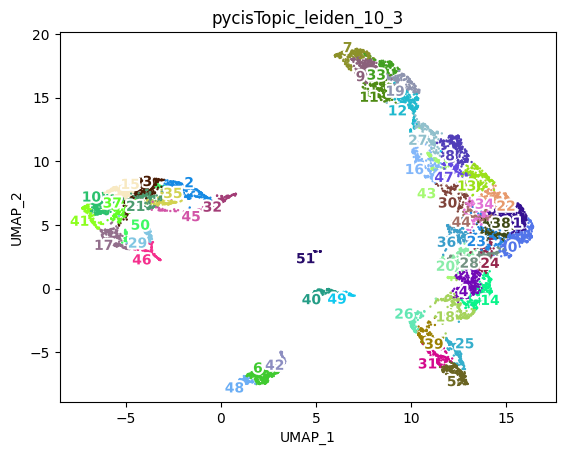

In [18]:
###################################
# plot clusters agains cell types #
###################################

plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['predicted.celltype.azi.l1', 
               'predicted.celltype.azi.l2', 
               'predicted.celltype.azi.l3', 
               'pycisTopic_leiden_10_0.6', 
               'pycisTopic_leiden_10_1.2', 
               'pycisTopic_leiden_10_3'],
    target='cell', num_columns=1,
    text_size=10,
    dot_size=.5)


In [20]:
##########################
# save pycistopic object #
##########################

# location to store the object
pycistopic_object_wtopics_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/reconstructed/10k_10_topics_pycistopic_object.pkl'

# save the object
with open(pycistopic_object_wtopics_loc, 'wb') as f:
   pickle.dump(cistopic_obj, f)


In [25]:
######################
# perform imputation #
######################

# impute regions
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)


2025-05-15 07:01:15,059 cisTopic     INFO     Imputing region accessibility
2025-05-15 07:01:15,059 cisTopic     INFO     Impute region accessibility for regions 0-20000
2025-05-15 07:01:15,600 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2025-05-15 07:01:15,945 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2025-05-15 07:01:16,297 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2025-05-15 07:01:16,650 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2025-05-15 07:01:17,011 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2025-05-15 07:01:17,362 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2025-05-15 07:01:17,709 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2025-05-15 07:01:18,065 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2025-05-15 07:01:18,430 cisTopic     

In [26]:
##########################
# save pycistopic object #
##########################

# location to store the object
pycistopic_object_imputed_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/reconstructed/10k_10_topics_imputed_pycistopic_object.pkl'

# save the object
with open(pycistopic_object_imputed_loc, 'wb') as f:
   pickle.dump(cistopic_obj, f)


In [27]:
###########################
# normalize accessibility #
###########################

# normalize object
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)


2025-05-15 07:50:05,718 cisTopic     INFO     Normalizing imputed data
2025-05-15 07:50:17,169 cisTopic     INFO     Done!


In [28]:
################################
# get most contributing topics #
################################

# get the topics
cell_topics = cistopic_obj.selected_model.cell_topic.T
# Highest contributing topic per cells
highest_topic = cell_topics.apply(lambda x: cell_topics.columns[np.argmax(x)], axis = 1)
# second highest condtributing topic
second_highest_topic = cell_topics.apply(lambda row: row.nlargest(2).index[-1],axis=1)
# add to cell_data
cistopic_obj.cell_data['most_contributing_topic'] = highest_topic
cistopic_obj.cell_data['second_most_contributing_topic'] = second_highest_topic


2025-05-15 07:54:04,919 cisTopic     INFO     Calculating mean
2025-05-15 07:54:06,896 cisTopic     INFO     Calculating variance


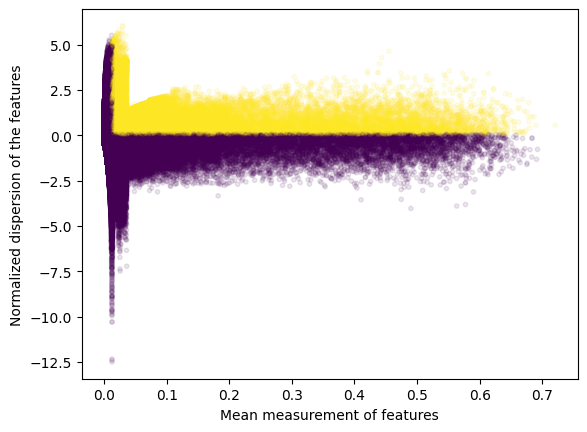

2025-05-15 07:54:29,149 cisTopic     INFO     Done!


In [30]:
#################################
# run variable region detection #
#################################

variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)


In [34]:
##################################################
# run DAR identification using wilcoxon-rank-sum #
##################################################

# Run DAR analysis
markers_dict = find_diff_features(
    cistopic_obj,
    imputed_acc_obj, 
    var_features = variable_regions,
    variable = 'most_contributing_topic',
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=8,
    _temp_dir=os.environ["TMPDIR"],
    split_pattern = '_'
)


2025-05-15 07:58:50,866	INFO worker.py:1724 -- Started a local Ray instance.


2025-05-15 07:58:51,404 cisTopic     INFO     Subsetting data for Topic1 (54 of 9282)
2025-05-15 07:58:51,541 cisTopic     INFO     Computing p-value for Topic1
2025-05-15 07:58:57,271 cisTopic     INFO     Computing log2FC for Topic1
2025-05-15 07:58:57,331 cisTopic     INFO     Topic1 done!
2025-05-15 07:58:57,336 cisTopic     INFO     Subsetting data for Topic2 (4974 of 9282)
2025-05-15 07:58:57,463 cisTopic     INFO     Computing p-value for Topic2
2025-05-15 07:59:03,134 cisTopic     INFO     Computing log2FC for Topic2
2025-05-15 07:59:03,193 cisTopic     INFO     Topic2 done!
2025-05-15 07:59:03,199 cisTopic     INFO     Subsetting data for Topic3 (1820 of 9282)
2025-05-15 07:59:03,322 cisTopic     INFO     Computing p-value for Topic3
2025-05-15 07:59:09,180 cisTopic     INFO     Computing log2FC for Topic3
2025-05-15 07:59:09,240 cisTopic     INFO     Topic3 done!
2025-05-15 07:59:09,246 cisTopic     INFO     Subsetting data for Topic4 (56 of 9282)
2025-05-15 07:59:09,330 cisT

In [35]:
#########################
# convert DARs to table #
#########################

# add the region as an explicit column
for topic, topic_df in markers_dict.items():
    # extract the df and add the region as an explicit column
    topic_df = pd.concat([pd.DataFrame({'region' : topic_df.index}, index = topic_df.index), topic_df], axis = 1)
    # put back in the list
    markers_dict[topic] = topic_df

# now merge all of the tables together
dars_table = pd.concat(markers_dict.values(), ignore_index=True)

# write this as a table
dars_table_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/dar_detection/10k_10_topics_dars.tsv.gz'
dars_table.to_csv(dars_table_loc, sep = '\t', index = False, header = True, compression = 'gzip')


In [36]:
###################################
# get celltype DAR identification #
###################################

# Run DAR analysis
markers_dict_ct = find_diff_features(
    cistopic_obj,
    imputed_acc_obj, 
    var_features = variable_regions,
    variable = 'predicted.celltype.azi.l1',
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=8,
    _temp_dir=os.environ["TMPDIR"],
    split_pattern = '_'
)

2025-05-15 08:01:27,254	INFO worker.py:1724 -- Started a local Ray instance.


2025-05-15 08:01:27,819 cisTopic     INFO     Subsetting data for B (479 of 9282)
2025-05-15 08:01:27,932 cisTopic     INFO     Computing p-value for B
2025-05-15 08:01:33,744 cisTopic     INFO     Computing log2FC for B
2025-05-15 08:01:33,800 cisTopic     INFO     B done!
2025-05-15 08:01:33,805 cisTopic     INFO     Subsetting data for CD4 T (3551 of 9282)
2025-05-15 08:01:33,930 cisTopic     INFO     Computing p-value for CD4 T
2025-05-15 08:01:38,816 cisTopic     INFO     Computing log2FC for CD4 T
2025-05-15 08:01:38,872 cisTopic     INFO     CD4 T done!
2025-05-15 08:01:38,877 cisTopic     INFO     Subsetting data for CD8 T (1440 of 9282)
2025-05-15 08:01:38,993 cisTopic     INFO     Computing p-value for CD8 T
2025-05-15 08:01:44,506 cisTopic     INFO     Computing log2FC for CD8 T
2025-05-15 08:01:44,559 cisTopic     INFO     CD8 T done!
2025-05-15 08:01:44,564 cisTopic     INFO     Subsetting data for DC (140 of 9282)
2025-05-15 08:01:44,648 cisTopic     INFO     Computing p-

In [ ]:
############################
# convert ct DARs to table #
############################

# add the region as an explicit column
for ct, ct_df in markers_dict_ct.items():
    # extract the df and add the region as an explicit column
    ct_df = pd.concat([pd.DataFrame({'region' : ct_df.index}, index = ct_df.index), ct_df], axis = 1)
    # put back in the list
    markers_dict_ct[ct] = ct_df

# now merge all of the tables together
dars_table_ct = pd.concat(markers_dict_ct.values(), ignore_index=True)

# write this as a table
dars_table_ct_loc = '/groups/umcg-franke-scrna/tmp04/external_datasets/10x_multiome_10k_pbmcs/pycistopic/dar_detection/10k_l1celltypes_dars.tsv.gz'
dars_table_ct.to_csv(dars_table_ct_loc, sep = '\t', index = False, header = True, compression = 'gzip')
